In [1]:
%load_ext autoreload
%autoreload 2

In [177]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

from utils import build_vocab, evaluate_baselines
from models import RecurrentModel, VanillaRNNBlock, GRUBlock, LSTMBlock
from nameTrainer import NameTrainer
from pipeline import ModelRunner
from torchModels import analyze_vanishing_gradient_torch, analyze_vanishing_gradient_torch_name

# Загрузка и анализ данных (#2)

In [63]:
df = pd.read_csv(r'data/babynames-clean.csv', header=None)
df.columns = ['name', "gender"]

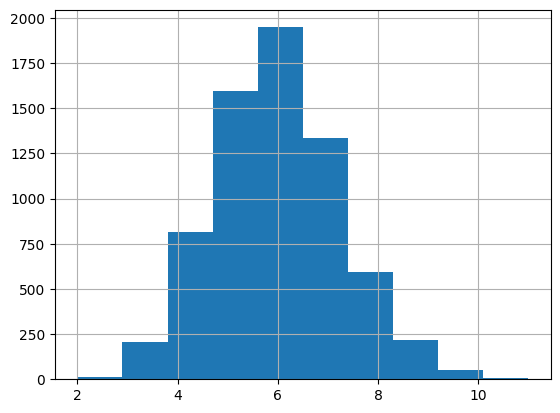

In [ ]:
df.name.str.len().hist();

In [ ]:
df.gender.value_counts()/df.shape[0]*100

gender
boy     50.678266
girl    49.321734
Name: count, dtype: float64

In [64]:
cleaned = df.name.str.strip()
cleaned = df.name.str.lower()

In [144]:
cleaned.str.len().value_counts()

name
6     1948
5     1596
7     1335
4      817
8      591
9      217
3      209
10      52
2       10
11       7
Name: count, dtype: int64

In [9]:
cleaned.str.split("").explode().value_counts()

name
     13564
a     5593
e     5038
n     3524
i     3264
l     3255
r     3070
o     2071
t     1745
s     1674
d     1532
m     1245
y     1243
h     1206
c     1063
u      707
b      673
k      616
g      526
j      502
v      490
f      302
w      271
p      265
z      199
x       71
q       61
Name: count, dtype: int64

# Подготовка данных (№3)

In [65]:
df.gender = (df.gender == "boy")*1

In [66]:
with_tokens = [f"<{name}>" for name in cleaned]
max_len = max(len(s) for s in with_tokens)
padded = [s.ljust(max_len, ' ') for s in with_tokens]

In [12]:
max_len

13

In [67]:
tokens, token2id, id2token = build_vocab(padded)

In [68]:
encoded = np.zeros((len(padded), max_len), dtype=np.int64)
    
for i, name in enumerate(padded):
    encoded[i] = [token2id[ch] for ch in name]

In [69]:
X_train, X_temp, y_train, y_temp = train_test_split(
    encoded, df.gender, test_size=0.2, random_state=42, stratify=df.gender
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [71]:
X_train_t = torch.from_numpy(X_train).long()
X_valid_t = torch.from_numpy(X_valid).long()
X_test_t  = torch.from_numpy(X_test).long()

y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
y_valid_t = torch.tensor(y_valid.values, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
valid_dataset = TensorDataset(X_valid_t, y_valid_t)
test_dataset  = TensorDataset(X_test_t,  y_test_t)

In [72]:
BATCH_SIZE = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Next char prediction . №4 & №5 & №6

In [132]:
models_names = ModelRunner(['VanillaRNNBlock', 'GRUBlock', 'LSTMBlock'], len(tokens))

ModelRunner инициализирован для блоков: ['VanillaRNNBlock', 'GRUBlock', 'LSTMBlock']


In [133]:
models_names.train_models(train_loader, valid_loader, 25, use_next_char_loss = True)


Обучение VanillaRNNBlock...
Epoch 1:next_train=1.7035, next_valid=1.3615
Epoch 10:next_train=1.1691, next_valid=1.1826
Epoch 20:next_train=1.0975, next_valid=1.1539
Epoch 25:next_train=1.0706, next_valid=1.1396
VanillaRNNBlock: обучение завершено

Обучение GRUBlock...
Epoch 1:next_train=1.7746, next_valid=1.4141
Epoch 10:next_train=1.1393, next_valid=1.1657
Epoch 20:next_train=1.0390, next_valid=1.1289
Epoch 25:next_train=0.9999, next_valid=1.1263
GRUBlock: обучение завершено

Обучение LSTMBlock...
Epoch 1:next_train=1.8720, next_valid=1.4451
Epoch 10:next_train=1.1421, next_valid=1.1643
Epoch 20:next_train=1.0433, next_valid=1.1245
Epoch 25:next_train=1.0070, next_valid=1.1224
LSTMBlock: обучение завершено


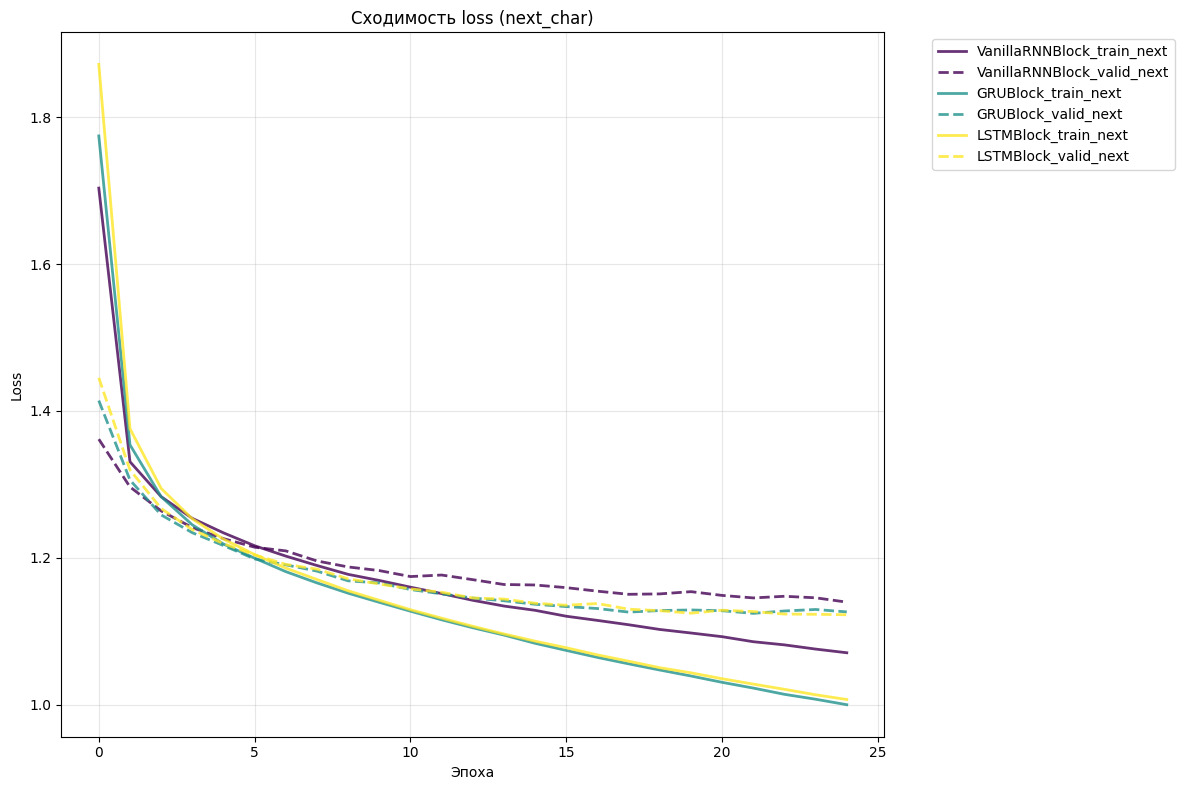

In [134]:
models_names.plot_losses(loss_type='next_char')

In [135]:
models_names.generate_names_comparison(token2id=token2id, id2token=id2token)


Сгенерированные имена:


,temp_0.7,temp_1.0,temp_1.3
VanillaRNNBlock,"ebby, herrie, erlan, elia, olijah","ierrot, amie, errie, ontem, earla","hermoymm, iquelda, jascamui, entonora, ilupraifo"
GRUBlock,"reas, estell, lura, rileen, istian","myas, levina, eeda, aid, laty","simmott, riddie, yain, izkhae, ezzy"
LSTMBlock,"ontherthud, ullert, averzh, alisa, eld","iliadalmes, ikimar, azeb, avayn, imwina","arphyllefphoq, encexzordoror, aidely, divne, e..."


In [136]:
models_names.compute_roc_auc(test_loader)


ROC AUC по моделям:


,train_roc_auc,valid_roc_auc,test_roc_auc
VanillaRNNBlock,0.416,0.371,0.412
GRUBlock,0.375,0.403,0.382
LSTMBlock,0.453,0.449,0.437


# Сравнение моделей по качеству прогнозирования имен (№7)

In [138]:
models_names.compute_perplexity()


Perplexity по моделям:


,ppl_ce,ppl_manual
VanillaRNNBlock,7.2183,7.2183
GRUBlock,6.9893,6.9893
LSTMBlock,6.9500,6.9500


In [100]:
evaluate_baselines(test_loader, len(tokens), token2id)

Random Model PPL: 29.0000
Frequency Model PPL: 16.941


# Классификация по полу (№8)

In [79]:
models_gender = ModelRunner(['VanillaRNNBlock', 'GRUBlock', 'LSTMBlock'], len(tokens))

ModelRunner инициализирован для блоков: ['VanillaRNNBlock', 'GRUBlock', 'LSTMBlock']


In [80]:
models_gender.train_models(train_loader, valid_loader, 25, use_gender_loss = True)


Обучение VanillaRNNBlock...
Epoch 1:, gender_train=0.6387, gender_valid=0.5167
Epoch 10:, gender_train=0.3719, gender_valid=0.4410
Epoch 20:, gender_train=0.2753, gender_valid=0.4405
Epoch 25:, gender_train=0.2345, gender_valid=0.4762
VanillaRNNBlock: обучение завершено

Обучение GRUBlock...
Epoch 1:, gender_train=0.5600, gender_valid=0.4912
Epoch 10:, gender_train=0.2889, gender_valid=0.4282
Epoch 20:, gender_train=0.1283, gender_valid=0.5539
Epoch 25:, gender_train=0.0920, gender_valid=0.6549
GRUBlock: обучение завершено

Обучение LSTMBlock...
Epoch 1:, gender_train=0.6052, gender_valid=0.4995
Epoch 10:, gender_train=0.3106, gender_valid=0.4224
Epoch 20:, gender_train=0.1633, gender_valid=0.5093
Epoch 25:, gender_train=0.1115, gender_valid=0.6336
LSTMBlock: обучение завершено


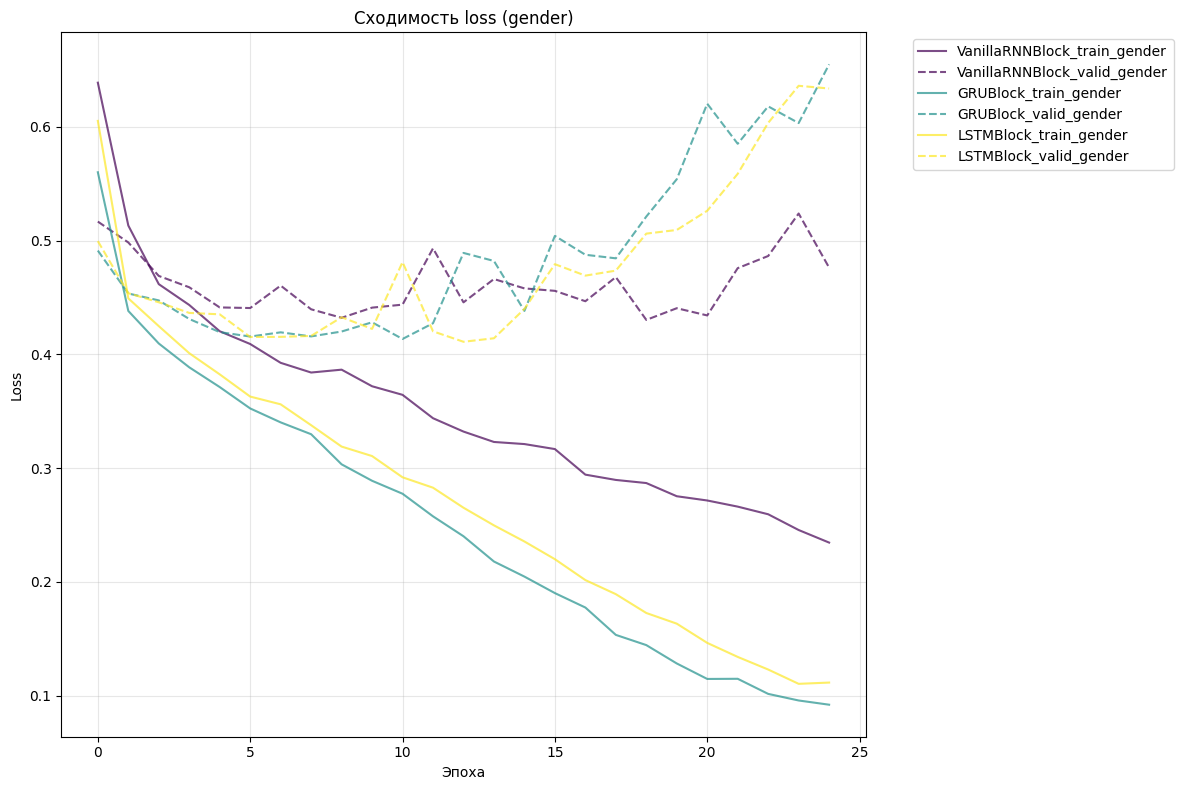

In [81]:
models_gender.plot_losses(loss_type='gender')

In [82]:
models_gender.generate_names_comparison(token2id=token2id, id2token=id2token)


Сгенерированные имена:


,temp_0.7,temp_1.0,temp_1.3
VanillaRNNBlock,"crjqdxdboscji, tgr, , umvyrlp, tjhhskcfwlcbd","wxnoqpbdyu y, hjtikvdhtpso , yreqsauhzdgv, ja,...","xjihidddhxfvc, vsgoofuyu, gjeje pgxxsjw, ihdzs..."
GRUBlock,"egyxlwsdkgt, oklkuvl oqen, bwhaiqw ffvlb, rdj...","rbxpstiaonfl, pkcjhoptxgehq, qahaoxdqkrayd, pn...","lrsiz sxrmvkj, q, lfgumuepvqmpi, zzzwxzxzv, tq..."
LSTMBlock,"gtfoqgdnnqfnk, d, przbgubdnay, uk obznbaioip, ...","lbfpdjiqeus, lynaaodbkjslu, spnekfrqbtdgq, bun...","fsk, htknqwjchcfsq, bi, vszpzdfykcqg, lsibodpt..."


In [168]:
models_gender.compute_roc_auc(test_loader)


ROC AUC по моделям:


,train_roc_auc,valid_roc_auc,test_roc_auc
VanillaRNNBlock,0.977,0.887,0.916
GRUBlock,0.997,0.886,0.908
LSTMBlock,0.995,0.895,0.915


# Vanishing Gradient (№9)


=== Анализ Vanishing Gradient (Standard PyTorch Models) Gender ===
Mode length: 8
Training RNN...
Training LSTM...
Training GRU...


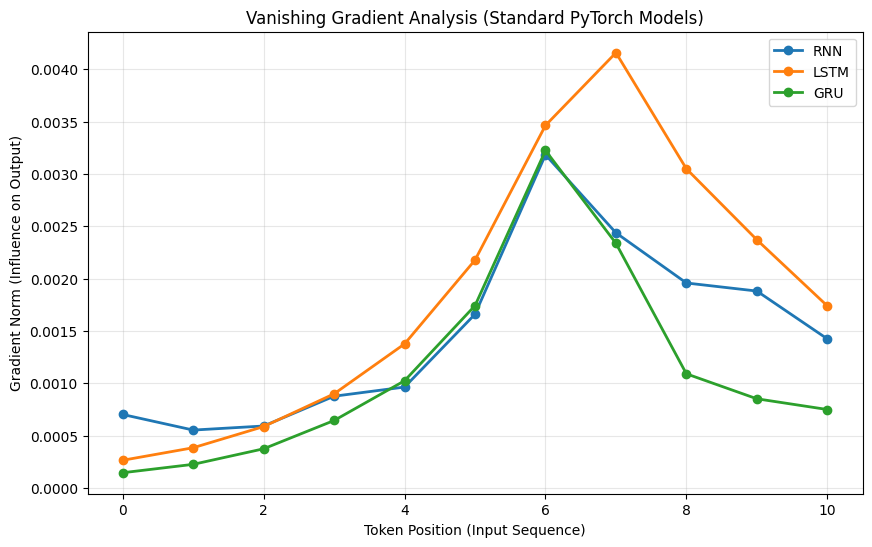

In [176]:
analyze_vanishing_gradient_torch(X_train, y_train, token2id)


=== Анализ Vanishing Gradient (Task: Name Generation) ===
Mode length: 6
Training RNN...
Training LSTM...
Training GRU...


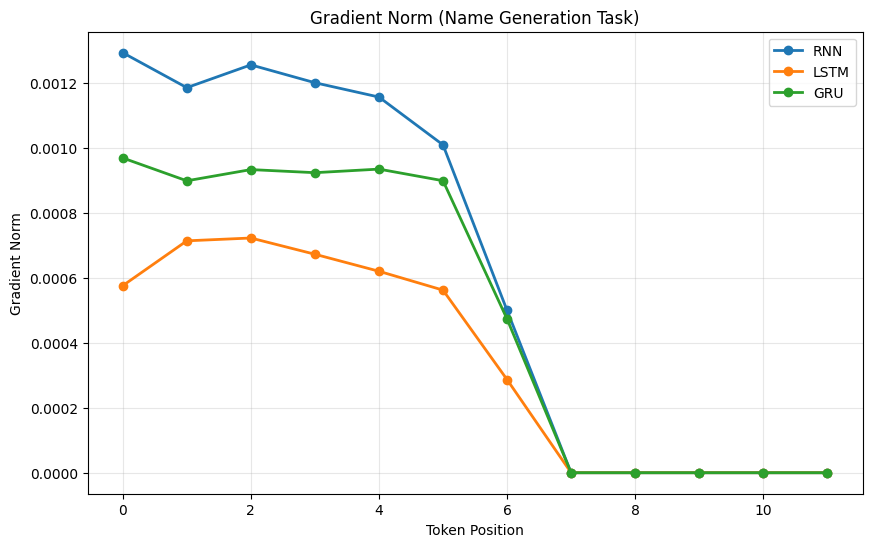

In [180]:
analyze_vanishing_gradient_torch_name(X_train, token2id)

# Multitask Learning (№10)

In [113]:
models_both = ModelRunner(['GRUBlock', 'LSTMBlock'], len(tokens))

ModelRunner инициализирован для блоков: ['GRUBlock', 'LSTMBlock']


In [114]:
models_both.train_models(train_loader, valid_loader, 25, use_next_char_loss = True, use_gender_loss = True)


Обучение GRUBlock...
Epoch 1:next_train=1.8038, next_valid=1.4159, gender_train=0.6556, gender_valid=0.5837
Epoch 10:next_train=1.2195, next_valid=1.2084, gender_train=0.3168, gender_valid=0.4132
Epoch 20:next_train=1.1759, next_valid=1.1771, gender_train=0.1699, gender_valid=0.4816
Epoch 25:next_train=1.1634, next_valid=1.1706, gender_train=0.1142, gender_valid=0.5472
GRUBlock: обучение завершено

Обучение LSTMBlock...
Epoch 1:next_train=1.8921, next_valid=1.4540, gender_train=0.6905, gender_valid=0.6555
Epoch 10:next_train=1.2218, next_valid=1.2107, gender_train=0.3244, gender_valid=0.4193
Epoch 20:next_train=1.1791, next_valid=1.1835, gender_train=0.1903, gender_valid=0.4715
Epoch 25:next_train=1.1641, next_valid=1.1758, gender_train=0.1386, gender_valid=0.4981
LSTMBlock: обучение завершено


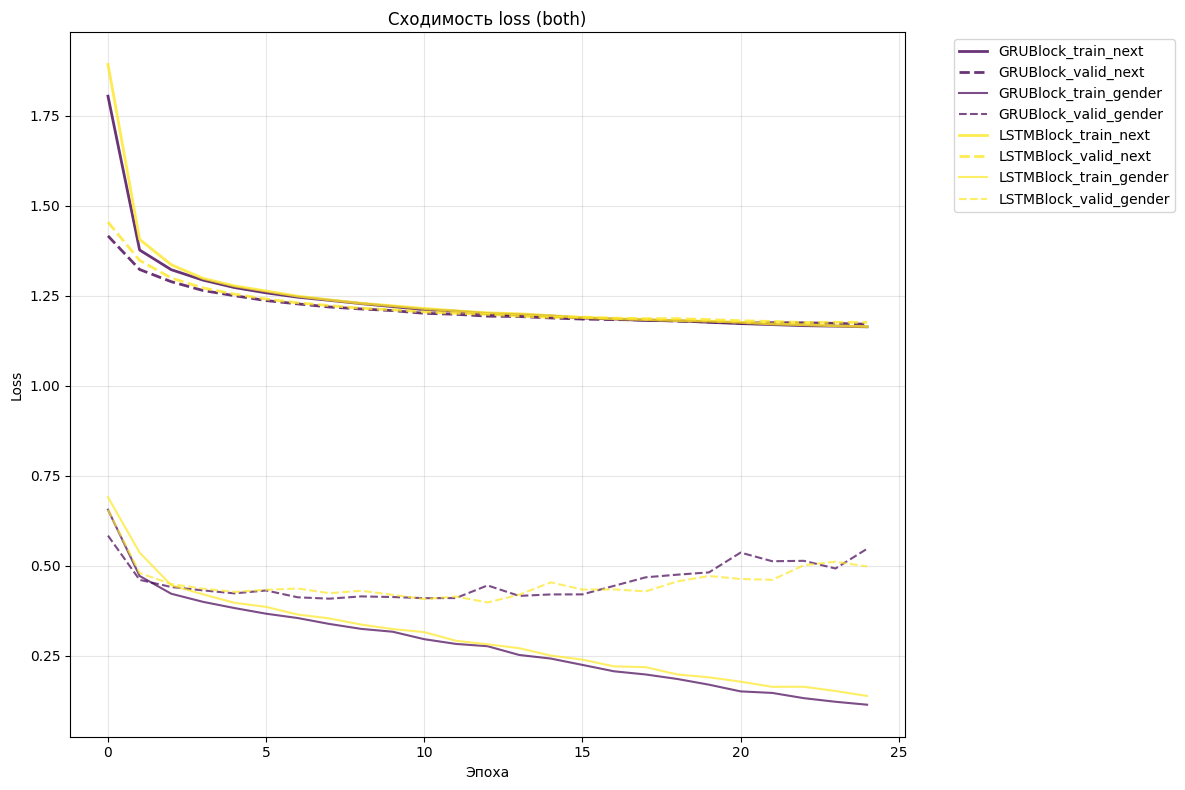

In [115]:
models_both.plot_losses(loss_type='both')

In [116]:
models_both.generate_names_comparison(token2id=token2id, id2token=id2token)


Сгенерированные имена:


,temp_0.7,temp_1.0,temp_1.3
GRUBlock,"ella, tamin, ton, mirgey, alyn","auarah, amarite, alane, sophell, jac","ahya, ebelh, hilyna, leliana, theciere"
LSTMBlock,"anshellenda, arthan, rodie, ervin, oc","lemittep , edyon, ason, eveo, rontel","kestira, alholvo, jycira, budah, nassa"


In [117]:
models_both.compute_roc_auc(test_loader)


ROC AUC по моделям:


,train_roc_auc,valid_roc_auc,test_roc_auc
GRUBlock,0.994,0.901,0.908
LSTMBlock,0.993,0.908,0.914


In [ ]:
torch.save(models_both.models_gender["LSTMBlock"], r"saved_model/full_model.pkl")

# embeddings (№11)

Используем модель: LSTMBlock
Обучаем PCA...
Обучаем t-SNE...


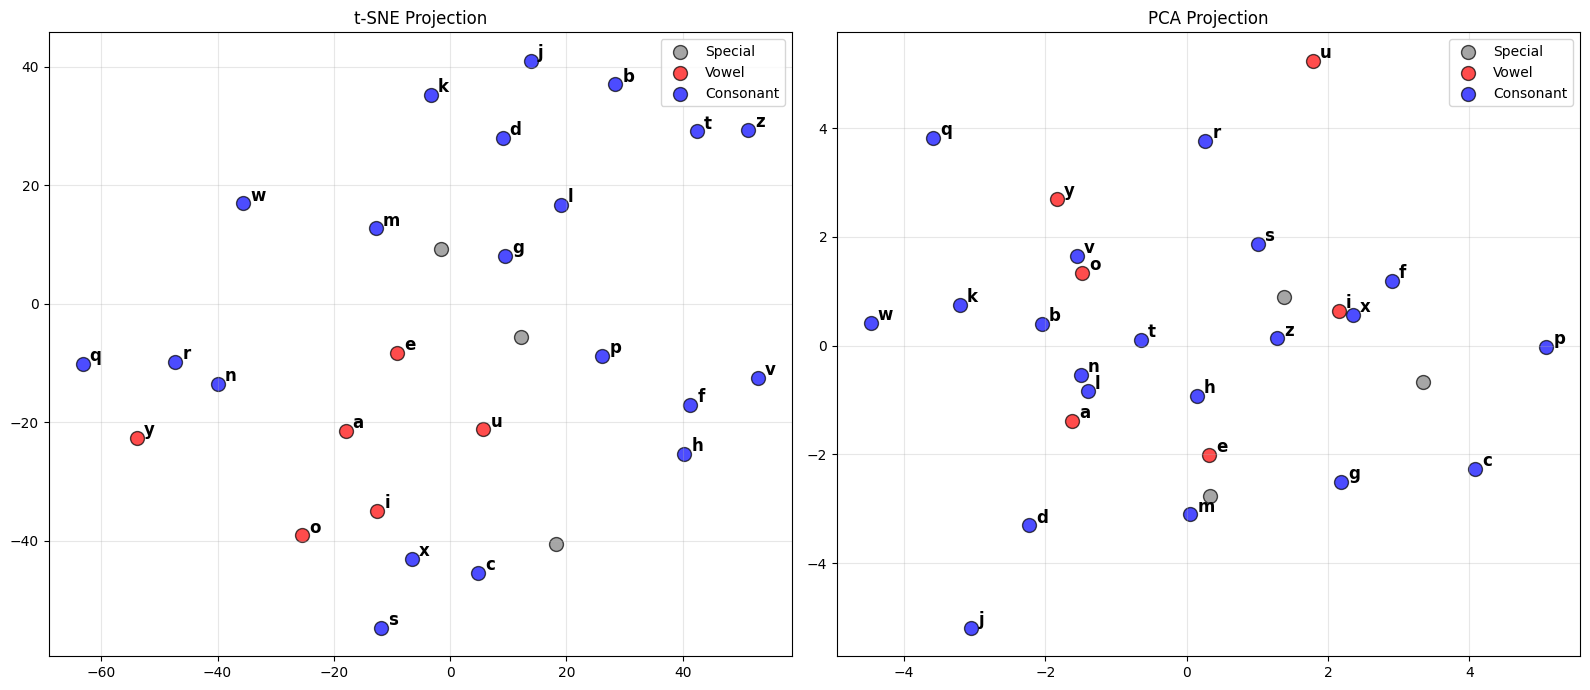

In [119]:
models_both.visualize_embeddings(id2token, "LSTMBlock")